In [ ]:
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')
import sys
root = '/content/drive/My Drive/dialog-data/'
#root = 'drive/dialog-data/'
sys.path.append(root)
!{sys.executable} -m pip install transformers==2.10
import time
import sys
import os
import torch as T
import numpy as np
import transformers as tf
import req_slot_data as D
from collections import defaultdict
import argparse
import pickle
from sklearn.metrics import precision_recall_fscore_support

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     |████████████████████████████████| 665kB 4.8MB/s 
     |████████████████████████████████| 1.1MB 13.7MB/s 
     |████████████████████████████████| 3.8MB 24.4MB/s 
     |████████████████████████████████| 890kB 50.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=f0cfaf1b5f6db0442ecc8d18a53e2006471a957e3f2ab4869973684d2e828fe7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
class Run:
    def __init__(self):
        self.records = defaultdict(list)
        
    def log(self, key, value):
        self.records[key].append(value)


def evaluate(model, batch):
    token_type_ids = batch.x.token_type_ids
    scores = model(batch.x.input_ids, batch.x.attention_mask, batch.x.token_type_ids)[0]
    mask = batch.x.attention_mask[..., 0] # B.C
    scores = scores + (mask.float() - 1) * 1e8
    #pos_weight = T.ones(scores.shape[1], device = scores.device) * 5
    loss = T.nn.functional.binary_cross_entropy_with_logits(scores, batch.y.float(),
                                                            reduction='sum')#, pos_weight=pos_weight)
    loss = loss/mask.shape[0]
    #loss = T.nn.functional.cross_entropy(scores, batch.y)
    return scores, loss

def metrics(scores, labels):
    with T.no_grad():
        preds = (T.sigmoid(scores) >= 0.5).float()
        acc = T.all(preds == labels.float(), dim=-1)
        preds = preds.view(-1).cpu().numpy()
        labels = labels.view(-1).cpu().numpy()
        precision, recall, f1score, _ = precision_recall_fscore_support(preds, labels,
                                                                              average='binary')
        correct = T.where(acc == True)[0]
        wrong = T.where(acc == False)[0]
        return [precision, recall, f1score], correct.cpu().numpy(), wrong.cpu().numpy()
    
def print_example(tokenizer, batch, idx, scores, correct):
    with T.no_grad():
        ids, token_type_ids, mask = batch.x.input_ids[idx], batch.x.token_type_ids[idx], batch.x.attention_mask[idx, :, 0]
        scores = scores[idx]
        state = ('Correct' if correct else 'Wrong')
        print(' '.join(tokenizer.convert_ids_to_tokens(ids[0, token_type_ids[0] == 0], skip_special_tokens=True)))
        total = int(mask.sum())
        print('\t'.join([' '.join(tokenizer.convert_ids_to_tokens(ids[i, token_type_ids[i] == 1],
                                                                  skip_special_tokens=True))
                         + ': {:.2f}'.format(T.sigmoid(scores)[i])
                         for i in range(total)] + [state]))

def train(model, optim, train_data, valid_data, no_batches, valid_duration=100,
          cuda=True, verbose=False, tokenizer=None, max_grad_norm=1.0,
          valid_size=1, run=None, batch_size=1, no_examples=10):
    if cuda:
        model = model.cuda()
    optim, scheduler = optim
    print("About to start training")
    start_time = time.time()
    metric = ['percision', 'recall', 'fscore']
    valid_loss, valid_acc, max_acc = 0, [0, 0, 0], 0
    print_gpu = False
    batch_size, total_batch_size = batch_size
    no_iter = total_batch_size//batch_size
    i = 0
    while True:
        optim.zero_grad()
        scores, loss, acc = 0, 0, [0, 0, 0]
        for k in range(no_iter):
            batch = next(train_data)
            scores_, loss_ = evaluate(model, batch)
            scores += scores_/no_iter
            loss_ /= no_iter
            loss_.backward()
            loss += loss_
            acc_, _, _ = metrics(scores_ , batch.y)
            acc = [a + acc_[j]/no_iter for j, a in enumerate(acc)]
        if max_grad_norm > 0:
            T.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        loss = float(loss)
        optim.step()
        scheduler.step()
        
        if  i % valid_duration == 0:
            model.eval()
            valid_acc, valid_loss = [0, 0, 0], 0
            with T.no_grad():
                if verbose:
                    print("##################################################################################")
                for k in range(valid_size):
                    batch = next(valid_data)
                    valid_scores, valid_los = evaluate(model, batch)
                    v_acc,  corr_ids, wrong_ids, = metrics(valid_scores, batch.y)
                    valid_loss += float(valid_los)
                    valid_acc = [a + v_acc[j]/valid_size for j, a in enumerate(valid_acc)]
                    if verbose and k < no_examples:
                        if len(corr_ids) > 0:
                            idx = np.random.choice(corr_ids)
                            print_example(tokenizer, batch, idx, valid_scores, correct=True)
                            print("-----------------------------------------------------------------------------")
                        if len(wrong_ids) > 0:
                            idx = np.random.choice(wrong_ids)
                            print_example(tokenizer, batch, idx, valid_scores, correct=False)
                            print("-----------------------------------------------------------------------------")
                if verbose:
                    print("##################################################################################")
                valid_loss /= valid_size
                if valid_acc[2] > max_acc:
                    max_acc = valid_acc[2]
                    model.save_model()        
            model.train()
        
        if print_gpu:
            print(nvgpu.gpu_info())
            print_gpu = False
        if run:
            run.log("train_loss", loss)
            for m, a, v_a in zip(metric, acc, valid_acc):
                run.log("valid_" + m, v_a)
                run.log("train_" + m, a)
            run.log("valid_loss", valid_loss)
            
            run.log("batch", i)
        train_str = ', '.join([f'train {m}: {a:.2f}' for m, a in zip(metric, acc)])
        valid_str = ', '.join([f'valid {m}: {a:.2f}' for m, a in zip(metric, valid_acc)])
        sys.stderr.write(f'\rtrain loss: {loss:.2f}\t{train_str}\t' + 
                         f'valid loss: {valid_loss:.2f}\t{valid_str}\t' +
                         f'batch: {i}\ttime: {time.time()-start_time:.2f}{"": <30}')
        i += 1
        if i >= no_batches - 1:
            break
    return model

def _in(n, trainable_parameters):
    return any(nd in n for nd in trainable_parameters)

def get_model(name, trainable_parameters=None):
    model_name = name.split('-')[0].capitalize()
    tokenizer = getattr(tf, f'{model_name}Tokenizer').from_pretrained(name)
    model = getattr(tf, f'{model_name}ForMultipleChoice').from_pretrained(name,
                                                                                  num_labels=4)
    if trainable_parameters is not None:
        for name, param in model.named_parameters():
            if not _in(name, trainable_parameters):
                param.requires_grad = False
    return tokenizer, model


class AdapterLayer(T.nn.Module):
    
    def __init__(self, input_size, dropout, hidden_size=64, init_scale=1e-3, act='gelu'):
        super().__init__()
        self.act = getattr(T.nn.functional, act)
        self.squeeze = T.nn.Linear(input_size, hidden_size)
        self.squeeze.weight.data.normal_(mean=0.0, std=init_scale)
        T.nn.init.zeros_(self.squeeze.bias.data)
        self.expand = T.nn.Linear(hidden_size, input_size)
        self.expand.weight.data.normal_(mean=0.0, std=init_scale)
        T.nn.init.zeros_(self.expand.bias.data)
        self.dropout = dropout
        
    def forward(self, x):
        x = self.dropout(x)
        return self.expand(self.act(self.squeeze(x))) + x
    

def add_adapter_layers(model, **kwargs):
    input_size = model.config.hidden_size
    layers = model.bert.encoder.layer
    for layer in layers:
        adapter1 = AdapterLayer(input_size, layer.attention.output.dropout, **kwargs)
        adapter2 = AdapterLayer(input_size, layer.output.dropout, **kwargs)
        layer.attention.output.add_module('dropout', adapter1)
        layer.output.add_module('dropout', adapter2)
    return model


def save_model(model, trainable_parameters, url):
    with open(url, 'wb') as f:
        params_to_save = {k: v.detach().cpu() for k, v in model.state_dict().items()
                          if _in(k, trainable_parameters)}
        pickle.dump(params_to_save, f)


def load_model(model, url):
    with open(url, 'rb') as f:
        return model.load_state_dict(pickle.load(f), False)


def main(args):
    
    data_dir = args.data_url
    trainable_parameters = (args.trainable_parameters.split(' ') if args.trainable_parameters != '' 
                                                                 else None)
    
    print("data directory is: " + data_dir)
    # Load the model
    tokenizer, model = get_model(args.model_name, trainable_parameters)
    # Load the data
    train_itr = D.RequestSlotDataset(os.path.join(data_dir,'train'), tokenizer, 
                            max_len=args.max_len).dataLoader(batch_size=args.batch_size,
                                                             shuffle=True, pin_memory=True,
                                                             cuda=True, loop=True, drop_last=True)
    valid_itr = D.RequestSlotDataset(os.path.join(data_dir,'dev'), tokenizer,
                              max_len=args.max_len).dataLoader(batch_size=args.batch_size,
                                                               shuffle=True, pin_memory=True,
                                                               cuda=True, loop=True, drop_last=True)
    # Train only adapter layers
    model = add_adapter_layers(model, hidden_size=args.adapter_size)
    if args.checkpoint:
        model.load_state_dict(pickle.load(open(os.path.join(data_dir, args.checkpoint), 'rb')), False)
    # Parallise if required
    if T.cuda.device_count() > 1:
        print("Let's use", T.cuda.device_count(), "GPUs!")
        model = T.nn.DataParallel(model)    
    # Create the optimizer
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() 
                       if _in(n, trainable_parameters) and not _in(n, no_decay)],
            "weight_decay": args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() 
                       if _in(n, trainable_parameters) and _in(n, no_decay)],
            "weight_decay": 0.0
        },
    ]
    if args.model_url is not None:
        save_fn = lambda : save_model(model, trainable_parameters, 
                                      os.path.join(data_dir, args.model_url))
    else:
        save_fn = type(None)
    setattr(model, 'save_model', save_fn)
    optimizer = tf.AdamW(optimizer_grouped_parameters, lr=args.lr, eps=1e-8)
    scheduler = tf.get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(0.1*args.num_batches), num_training_steps=args.num_batches
    )
    
    optim = [optimizer, scheduler]
    run = Run()
    model = train(model, optim, train_itr, valid_itr, args.num_batches, args.valid_duration,
                  verbose=args.verbose, tokenizer=tokenizer, max_grad_norm=args.max_grad_norm,
                  valid_size=args.valid_size, run=run, cuda=True,
                  batch_size=[args.batch_size, args.total_batch_size])
    return model, run

In [ ]:
# get command-line arguments
trainable_parameters = ['LayerNorm', 'dropout.expand', 'dropout.squeeze', 'classifier']
parser = argparse.ArgumentParser()
parser.add_argument('--model_name', type=str, default='bert-base-uncased')
parser.add_argument('--trainable_parameters', type=str, help='space separated parameters to train',
                    default=' '.join(trainable_parameters))
parser.add_argument('--total_batch_size', type=int, default=64, help='The total batch size')
parser.add_argument('--batch_size', type=int, default=64, help='The batch size')
parser.add_argument('--num_batches', type=int, default=1000, help='number of batches to train')
parser.add_argument('--max_len', type=int, default=120, help='Maximum length of the context')
parser.add_argument('--adapter_size', type=int, default=256, help='hidden size of the adapter layers')
parser.add_argument('--data_url', type=str, help='data directory')
parser.add_argument('--pos_prob', type=float, default=0.5, help='Probability of sampling positive examples')
parser.add_argument('--optim', type=str, default='Adam', help='data directory')
parser.add_argument('--lr', type=float, default=6e-5, help='Learning rate')
parser.add_argument('--amsgrad', type=bool, default=False, help=' whether to use the AMSGrad variant')
parser.add_argument('--weight_decay', type=float, default=0.006, help='L2 Regularization weight decay')
parser.add_argument('--max_grad_norm', default=1.0, type=float, help="Max gradient norm.")
parser.add_argument('--valid_duration', type=int, default=100, help='The number of batches before validating')
parser.add_argument('--verbose', type=bool, default=True, help='Show Live valid examples with prediction during validating')
parser.add_argument('--valid_size', type=int, default=50, help='The number of valid batches to evaluate')
parser.add_argument('--model_url', type=str, default='model.pkl', help='URL to save the model')
parser.add_argument('--checkpoint', type=str, help='Start training from a checkpoint')

args = parser.parse_args(['--data_url', root, '--adapter_size', '256', '--checkpoint', 'model_req_slot2.pkl',
                          '--batch_size', '12', '--total_batch_size', '120', '--num_batches', '3000',
                            '--model_url', 'model_req_slot2.pkl', '--max_len', '60',#, '--lr', '2e-5'
                            #'--weight_decay', '0.009'
                            ])
model, run = main(args)

data directory is: /content/drive/My Drive/dialog-data/
About to start training


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##################################################################################
user : ok , good service description : find one way and round trip flights to your favorite city
number of passengers to find flight seats for: 0.00	fare class of flight booking: 0.00	city in which the journey originates: 0.00	city in which the journey ends: 0.00	number of the airport flying out from: 0.00	number of the airport flying to: 0.00	date of departure flight: 0.00	date of return flight: 0.00	number of stops in the it ##iner ##ary: 0.00	local time of departure of flight from origin to destination: 0.00	local time of arrival of flight from origin to destination: 0.00	local time of arrival of flight from destination to origin: 0.00	local time of departure of flight from destination to origin: 0.00	price per passenger of the it ##iner ##ary: 0.00	number of bags to check in: 0.00	name of airline operating the flight: 0.00	whether the flight arrives the next day: 0.00	Correct
------------------------

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
train loss: 0.00	train percision: 0.70, train recall: 0.70, train fscore: 0.70	valid loss: 0.05	valid percision: 0.82, valid recall: 0.83, valid fscore: 0.82	batch: 66	time: 1107.53                              

In [ ]:
!nvidia-smi

Sat May 30 20:00:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
#save_model(model, trainable_parameters, root + 'model-cat-slot-best2.pkl')

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


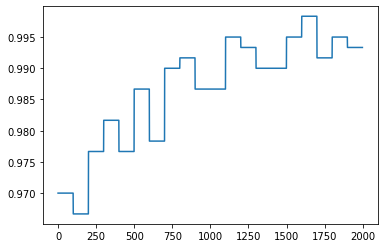

In [ ]:
plt.plot(run.records['valid_acc'])

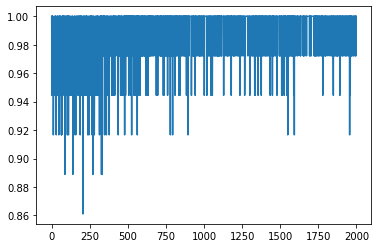

In [ ]:
plt.plot(run.records['train_acc'])

In [ ]:
trainable_parameters = ['LayerNorm', 'dropout.expand', 'dropout.squeeze', 'classifier']
save_model(model, trainable_parameters, root + 'model-cat-slot-best-512-14-05.pkl')

/home/osman/anaconda3/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [ ]:
tokenizer, model = get_model('bert-base-uncased', None)
model = add_adapter_layers(model, hidden_size=256)
load_model(model, root + 'model_req_slot2.pkl')

_IncompatibleKeys(missing_keys=['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.1.attention.self.query.weight', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.1.attention.self.key.bias', 'bert.encoder.layer.1.attention.self.val

In [ ]:
tokenizer = tf.BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
valid_dataset = D.RequestSlotDataset(os.path.join(root, 'dev'), tokenizer, max_len=120)
valid_data = valid_dataset.load_valid_data(batch_size=128)

In [ ]:
# Train only adapter layers
model = add_adapter_layers(model, hidden_size=256)
model.load_state_dict(pickle.load(open(os.path.join(root, 'model-cat-slot.pkl'), 'rb')), False)

_IncompatibleKeys(missing_keys=['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.1.attention.self.query.weight', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.1.attention.self.key.bias', 'bert.encoder.layer.1.attention.self.val

In [ ]:
def evaluate_valid_data(model, valid_data):
    model.eval()
    with T.no_grad():
        acc, count = 0, 0
        scores, slots, ids = [], [], []
        for i, batch in enumerate(valid_data):
            batch = D.RequestSlotDataset.map_to_cuda(batch)
            scores_, _ = evaluate(model, batch)
            acc_, _, _ = metrics(scores_, batch.y)
            acc += (acc_[-1]*len(batch.y))
            count += len(batch.y)
            scores.append(scores_.cpu().numpy())
            slots += batch.req_slot
            ids += batch.id
            sys.stderr.write(f'\r{i+1}/{len(valid_data)} acc: {acc_}{"": <30}')
        acc = acc/count
        scores = np.concatenate(scores)
    model.train()
    return {'acc': acc, 'scores': scores.tolist(), 'labels': slots, 'ids': ids}

In [ ]:
results = evaluate_valid_data(model.cuda(), valid_data)

163/204 acc: [1.0, 0.7241379310344828, 0.8400000000000001]                              /usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
204/204 acc: [1.0, 1.0, 1.0]                              

In [ ]:
print(results['acc'])

0.9310477156426169


In [ ]:
print(results['acc'])

0.9819954988747187


In [ ]:
print(results['acc'])

0.9515173280660801


In [ ]:
print(results['acc']) 46

0.9921810699588477


In [ ]:
print(results['acc'])

0.9285349668198061


In [ ]:
print(results['acc'])

0.9215586183426918


In [ ]:
print(results['labels'][403])

RideSharing_1--number_of_riders--1--2--3--4--0


In [ ]:
import json
with open(root + 'valid-cat-value-scores-512-14-05.json', 'w') as f:
    json.dump(results, f)
#print(acc)

In [ ]:
print(acc)

0.8336131631967764


In [ ]:
import data as D
import json

schema = D.SlotDataset._extract_categorical_schema(json.load(open(root + 'train/schema.json')))
data = [result for dialog in json.load(open(root + 'train/dialogues.json')) 
for result in D.extract_labels(dialog)
        if any([r[0] in schema for r in result['labels']['new_values']])]

In [ ]:
data[300]

{'context': {'acts': {'Flights_3--OFFER--airlines--Delta Airlines',
   'Flights_3--OFFER--number_stops--1',
   'Flights_3--OFFER--outbound_departure_time--6:40 am',
   'Flights_3--OFFER--price--$335'},
  'dialog_hist_intents': {'Flights_3--SearchOnewayFlight'},
  'dialog_hist_services': {'Flights_3'},
  'prev_turn_intents': {'Flights_3--SearchOnewayFlight'},
  'prev_turn_services': {'Flights_3'}},
 'correct': False,
 'labels': {'intents': {'Flights_3--SearchRoundtripFlights'},
  'new_values': {('Flights_3--airlines', 'Delta Airlines', 'Delta Airlines'),
   ('Flights_3--flight_class', 'dontcare', 'Economy')},
  'req_slots': set(),
  'services': {'Flights_3'},
  'values': {'Flights_3--airlines--Delta Airlines',
   'Flights_3--departure_date--9th of March',
   'Flights_3--destination_city--New York',
   'Flights_3--flight_class--dontcare',
   'Flights_3--number_checked_bags--0',
   'Flights_3--origin_city--Vancouver'}},
 'system': 'How about Delta Airlines at $335 per passenger that takes

In [ ]:
[scores, slots] = json.load(open(root + 'valid-scores.json'))

In [ ]:
scores[315]

[3.5242717266082764,
 3.93858003616333,
 -2.261160135269165,
 -2.1685099601745605,
 -3.6290156841278076,
 -0.06675952672958374,
 -100000000.0,
 -100000000.0,
 -100000000.0,
 -100000000.0,
 -100000000.0,
 -100000000.0,
 -100000000.0,
 -100000000.0]

In [ ]:
import numpy as np
def attach_predictions(data, slots, scores, schema):
    i = 0
    for j, datum in enumerate(data):
        correct = True
        new_values = set()
        labels = datum['labels']['new_values']
        num_slots = len([label for label in labels if label[0] in schema])
        for _ in range(num_slots):
            slot, score = slots[i], scores[i]
            idx = int(np.argmax(score))
            prediction = list(schema[slot][-1])[idx]
            value = [label[1] for label in labels if label[0]==slot][0]
            correct = correct and (prediction == value)
            new_values.add((slot, value, prediction))
            i += 1
        datum['labels']['new_values'] = new_values
        datum['correct'] = correct

In [ ]:
attach_predictions(data, slots, scores, schema)

In [ ]:
import pickle
with open(root + 'train-slot-dialogues.json', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
np.mean([v[1]==v[2] for d in data for v in d['labels']['new_values']])

0.8770060441850771

In [ ]:
np.mean([d['correct'] for d in data])

0.8640337833819068

In [ ]:
incorrect = [d for d in data if not d['correct']]

In [ ]:
wrong_slots = [v[0].split('--')[1] for d in incorrect for v in d['labels']['new_values'] if v[1] != v[2]]

In [ ]:
incrrpect